# Rainfall Prediction using Machine Learning

---
## 1. Importing Required Libraries

In [75]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# Model persistence
import joblib
import pickle

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-darkgrid')

print("All libraries imported successfully!")

All libraries imported successfully!


---
## 2. Loading the dataset

In [76]:
df = pd.read_csv('../dataset/Rainfall.csv')
print(f"\nDataset Shape: {df.shape}")
print(f"Total samples: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")


Dataset Shape: (366, 12)
Total samples: 366
Total features: 12


In [77]:
print("First 5 rows of the dataset:")
df

First 5 rows of the dataset:


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...
361,27,1022.7,18.8,17.7,16.9,15.0,84,90,yes,0.0,30.0,18.4
362,28,1026.6,18.6,17.3,16.3,12.8,75,85,yes,1.0,20.0,25.9
363,29,1025.9,18.9,17.7,16.4,13.3,75,78,yes,4.6,70.0,33.4
364,30,1025.3,19.2,17.3,15.2,13.3,78,86,yes,1.2,20.0,20.9


In [78]:
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     366 non-null    int64  
 1   pressure                366 non-null    float64
 2   maxtemp                 366 non-null    float64
 3   temparature             366 non-null    float64
 4   mintemp                 366 non-null    float64
 5   dewpoint                366 non-null    float64
 6   humidity                366 non-null    int64  
 7   cloud                   366 non-null    int64  
 8   rainfall                366 non-null    object 
 9   sunshine                366 non-null    float64
 10           winddirection  365 non-null    float64
 11  windspeed               365 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB


In [79]:
print("Statistical Summary:")
df.describe()

Statistical Summary:


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,365.000000,365.000000
mean,15.756831,1013.742623,26.191257,23.747268,21.894536,19.989071,80.177596,71.128415,4.419399,101.506849,21.536986
std,8.823592,6.414776,5.978343,5.632813,5.594153,5.997021,10.062470,21.798012,3.934398,81.723724,10.069712
min,1.000000,998.500000,7.100000,4.900000,3.100000,-0.400000,36.000000,0.000000,0.000000,10.000000,4.400000
25%,8.000000,1008.500000,21.200000,18.825000,17.125000,16.125000,75.000000,58.000000,0.500000,40.000000,13.700000
50%,16.000000,1013.000000,27.750000,25.450000,23.700000,21.950000,80.500000,80.000000,3.500000,70.000000,20.500000
75%,23.000000,1018.100000,31.200000,28.600000,26.575000,25.000000,87.000000,88.000000,8.200000,190.000000,27.900000
max,31.000000,1034.600000,36.300000,32.400000,30.000000,26.700000,98.000000,100.000000,12.100000,350.000000,59.500000


In [80]:
print("Column names:")
print(df.columns.tolist())


Column names:
['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection', 'windspeed']


In [81]:
df.columns = df.columns.str.strip()
print("\nCleaned column names:")
print(df.columns.tolist())


Cleaned column names:
['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection', 'windspeed']


---
## 3. Data Quality Assessment

### Checking for missing values

In [82]:
df.isnull().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
rainfall         0
sunshine         0
winddirection    1
windspeed        1
dtype: int64

In [83]:
## removing the missing value

df.dropna(inplace=True)
df.isnull().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
rainfall         0
sunshine         0
winddirection    0
windspeed        0
dtype: int64

### Checking for duplicate rows

In [84]:
df.duplicated().sum()

np.int64(0)

In [85]:
# Checking data types
print("Data Types:")
print(df.dtypes)

Data Types:
day                int64
pressure         float64
maxtemp          float64
temparature      float64
mintemp          float64
dewpoint         float64
humidity           int64
cloud              int64
rainfall          object
sunshine         float64
winddirection    float64
windspeed        float64
dtype: object


---
## 4. Target Variable Analysis (Class Imbalance Check)

Target Variable Distribution:
rainfall
yes    248
no     117
Name: count, dtype: int64

Percentage Distribution:
rainfall
yes    67.945205
no     32.054795
Name: proportion, dtype: float64


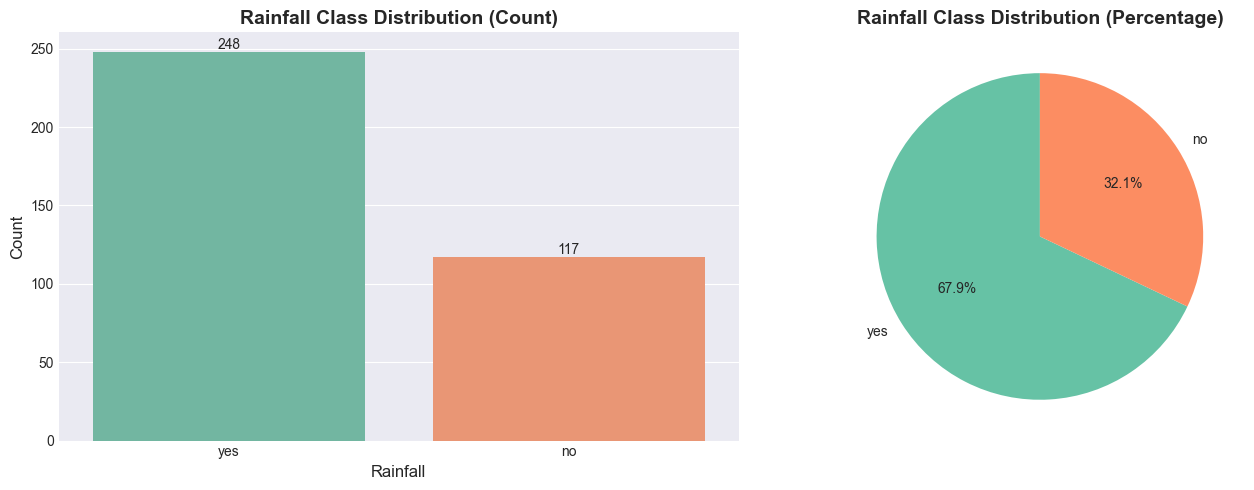

In [86]:
print("Target Variable Distribution:")
print(df['rainfall'].value_counts())
print("\nPercentage Distribution:")
print(df['rainfall'].value_counts(normalize=True) * 100)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(data=df, x='rainfall', ax=axes[0], palette='Set2')
axes[0].set_title('Rainfall Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rainfall', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

for container in axes[0].containers:
    axes[0].bar_label(container)

rainfall_counts = df['rainfall'].value_counts()
axes[1].pie(rainfall_counts, labels=rainfall_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=['#66c2a5', '#fc8d62'])
axes[1].set_title('Rainfall Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


---
## 5. Exploratory Data Analysis (EDA)

In [87]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")

Numerical Features (11): ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']



Distribution of Numerical Features


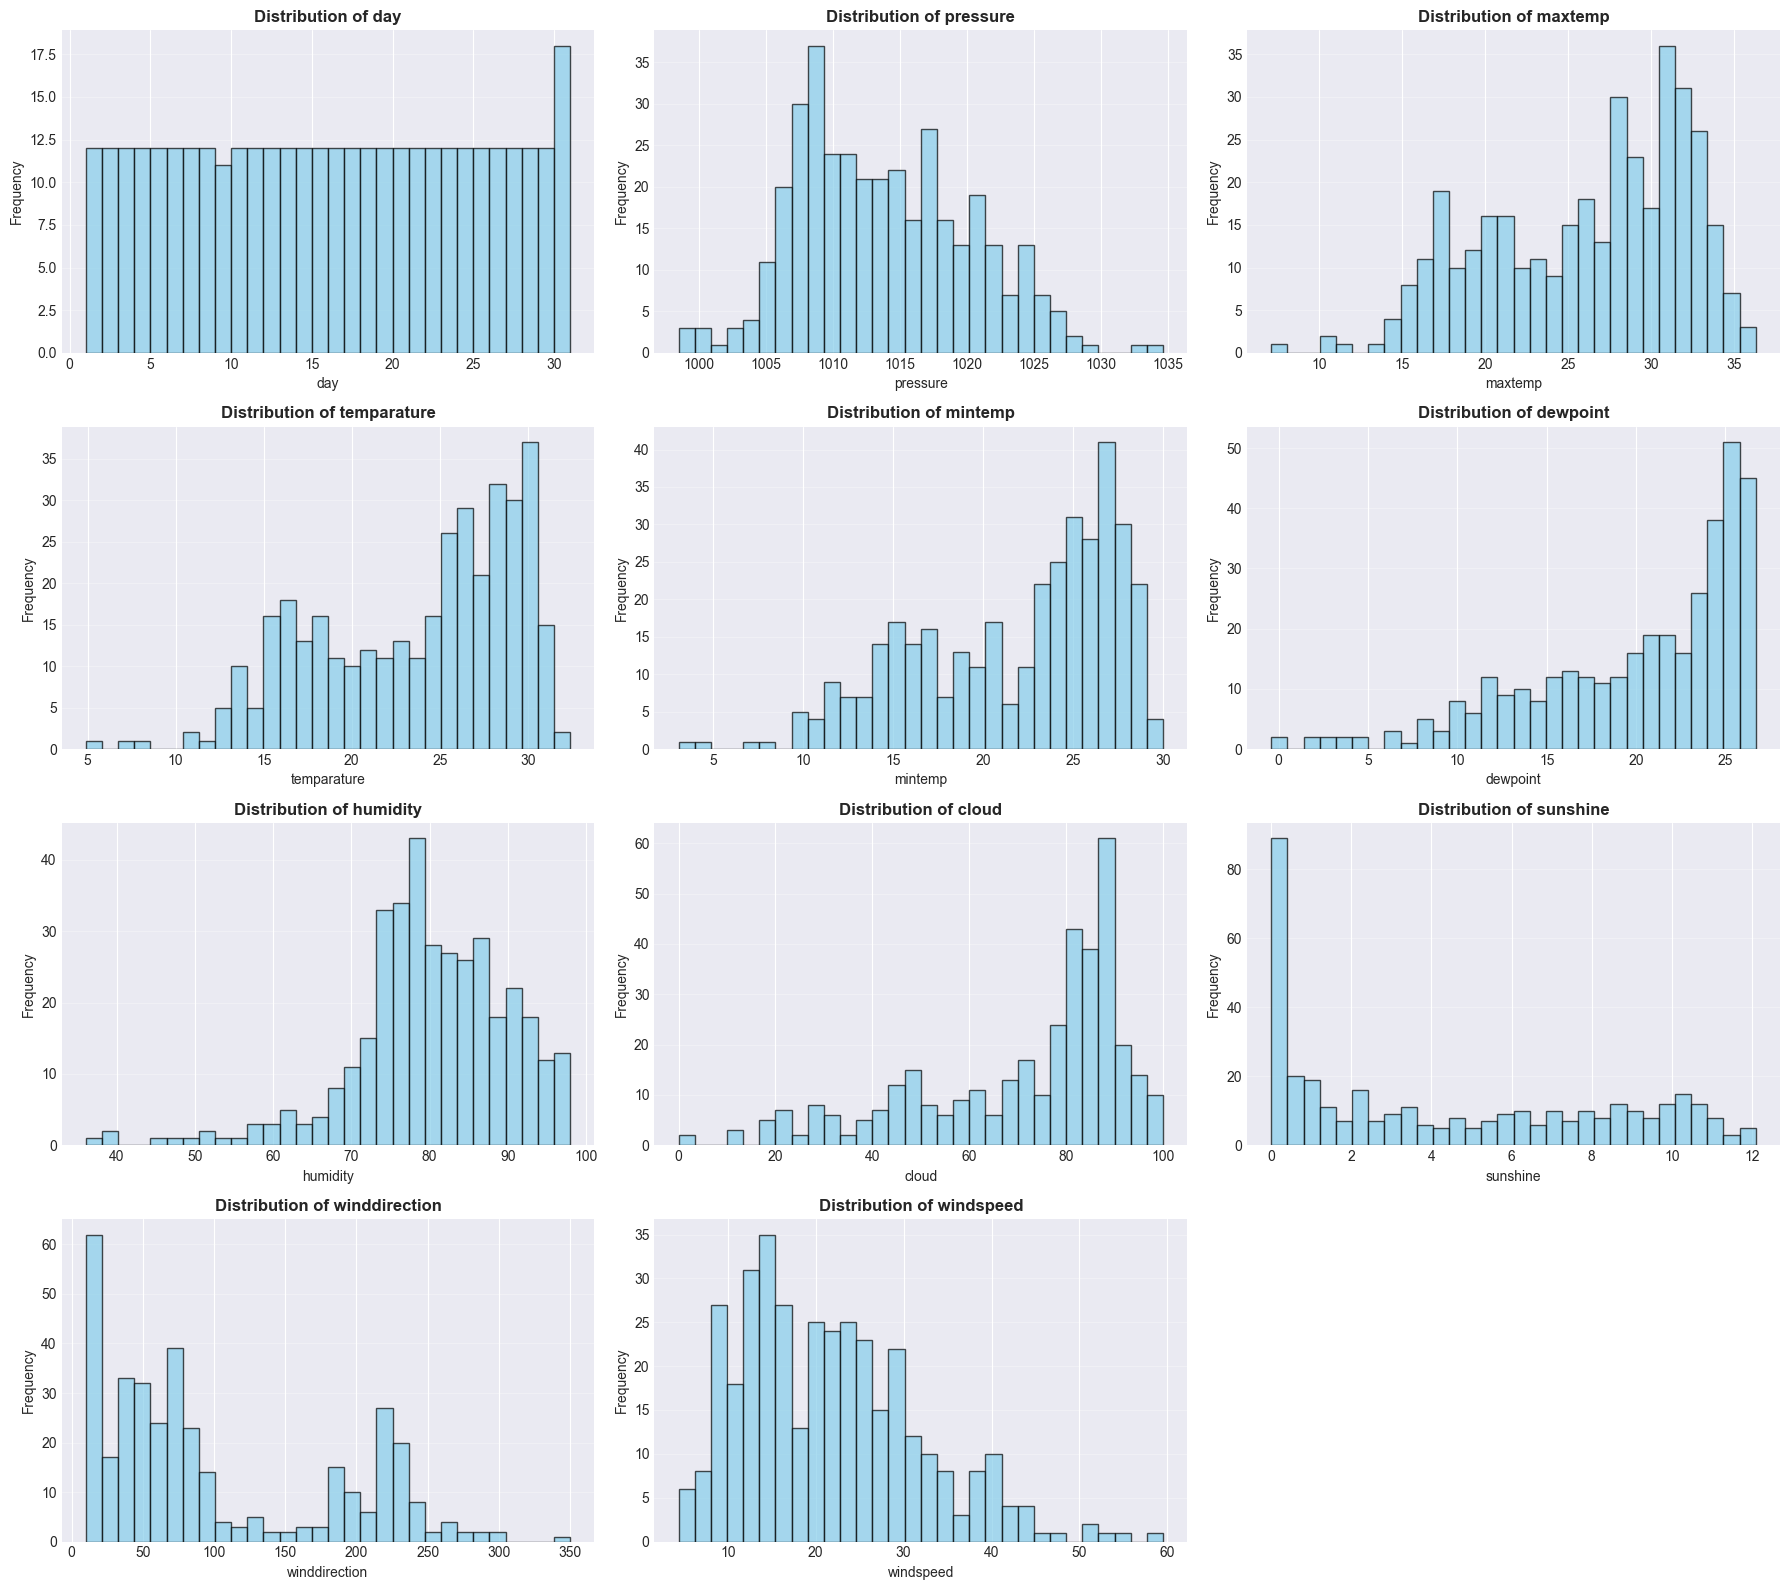

In [88]:
# Distribution of numerical features
print("\nDistribution of Numerical Features")

num_cols = len(numerical_features)
num_rows = (num_cols + 2) // 3 

fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    axes[idx].hist(df[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

for i in range(num_cols, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Box Plots for Outlier Detection


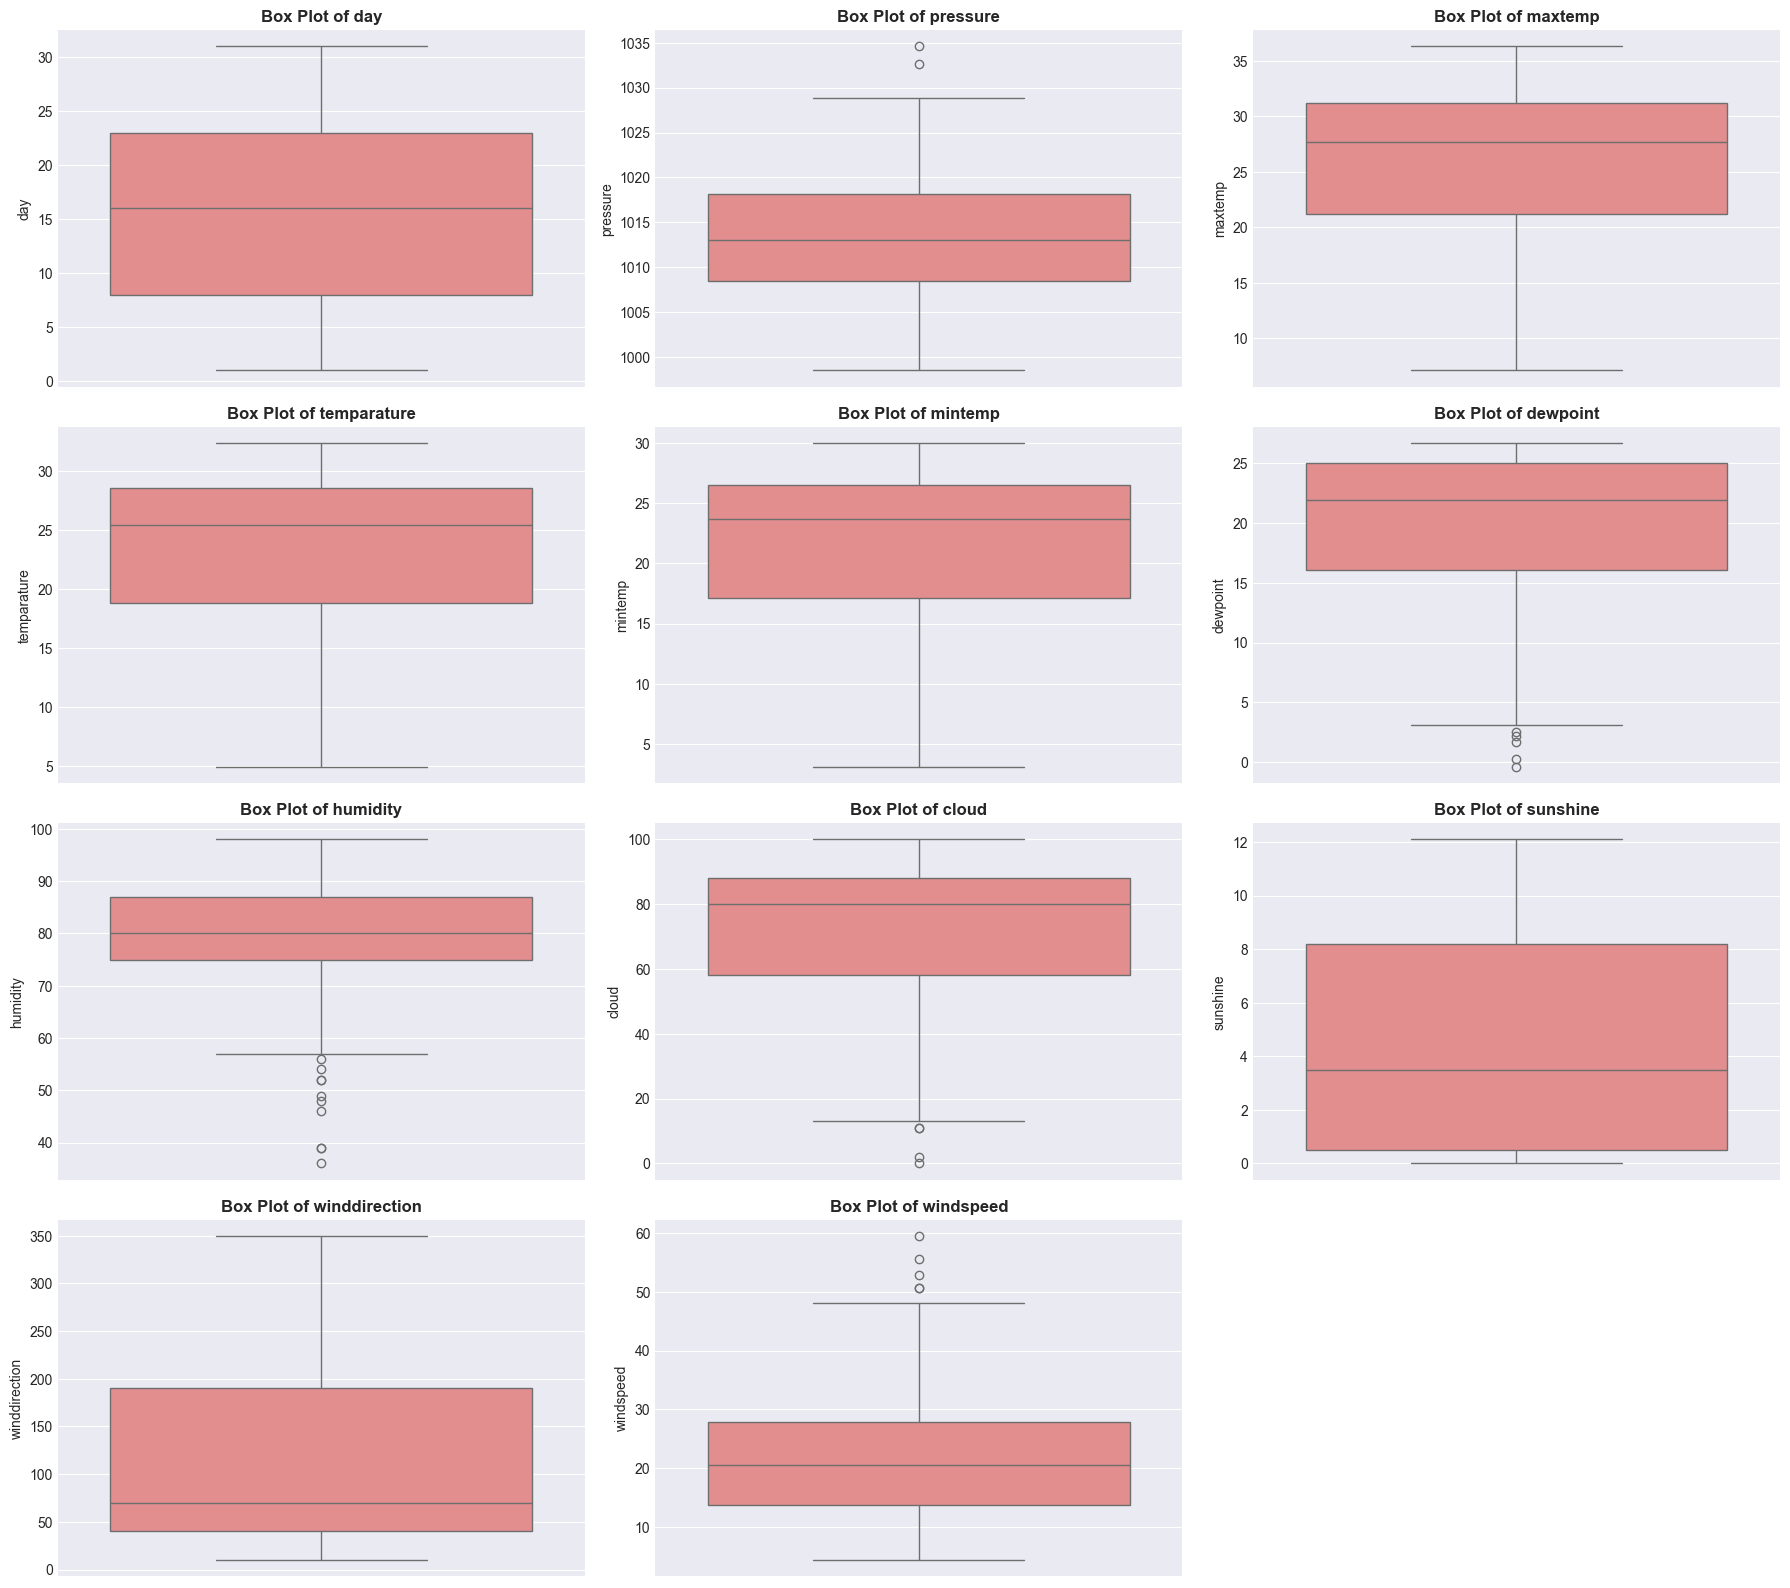

In [89]:
print("\nBox Plots for Outlier Detection")

fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    sns.boxplot(data=df, y=col, ax=axes[idx], color='lightcoral')
    axes[idx].set_title(f'Box Plot of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)

for i in range(num_cols, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [90]:
def remove_outliers_iqr(df, columns, threshold=1.5):
    """
    Removes outliers from the dataset using the IQR method.
    """
    df_clean = df.copy()
    original_shape = df_clean.shape
    
    print(f"Original Shape: {original_shape}")
    print(f"Detecting outliers with IQR Threshold: {threshold}")
    
    # Iterating through each column
    for col in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Defining bounds
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)
        
        # Identifying outliers
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        
        if len(outliers) > 0:
            print(f"   -> Removing {len(outliers)} outliers from '{col}' (Range: {lower_bound:.2f} to {upper_bound:.2f})")
            
        # Filtering the data
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        
    print(f"\nFinal Shape: {df_clean.shape}")
    print(f"Total rows removed: {original_shape[0] - df_clean.shape[0]}")
    
    return df_clean

columns_to_check = [
    'pressure', 'maxtemp', 'temparature', 'mintemp', 
    'dewpoint', 'humidity', 'cloud', 'sunshine', 
    'winddirection', 'windspeed'
]

df = remove_outliers_iqr(df, columns_to_check)

Original Shape: (365, 12)
Detecting outliers with IQR Threshold: 1.5
   -> Removing 2 outliers from 'pressure' (Range: 994.10 to 1032.50)
   -> Removing 5 outliers from 'dewpoint' (Range: 3.12 to 38.12)
   -> Removing 10 outliers from 'humidity' (Range: 59.50 to 103.50)
   -> Removing 1 outliers from 'cloud' (Range: 18.00 to 130.00)
   -> Removing 4 outliers from 'windspeed' (Range: -7.97 to 48.62)

Final Shape: (343, 12)
Total rows removed: 22



Box Plots for Outlier Detection


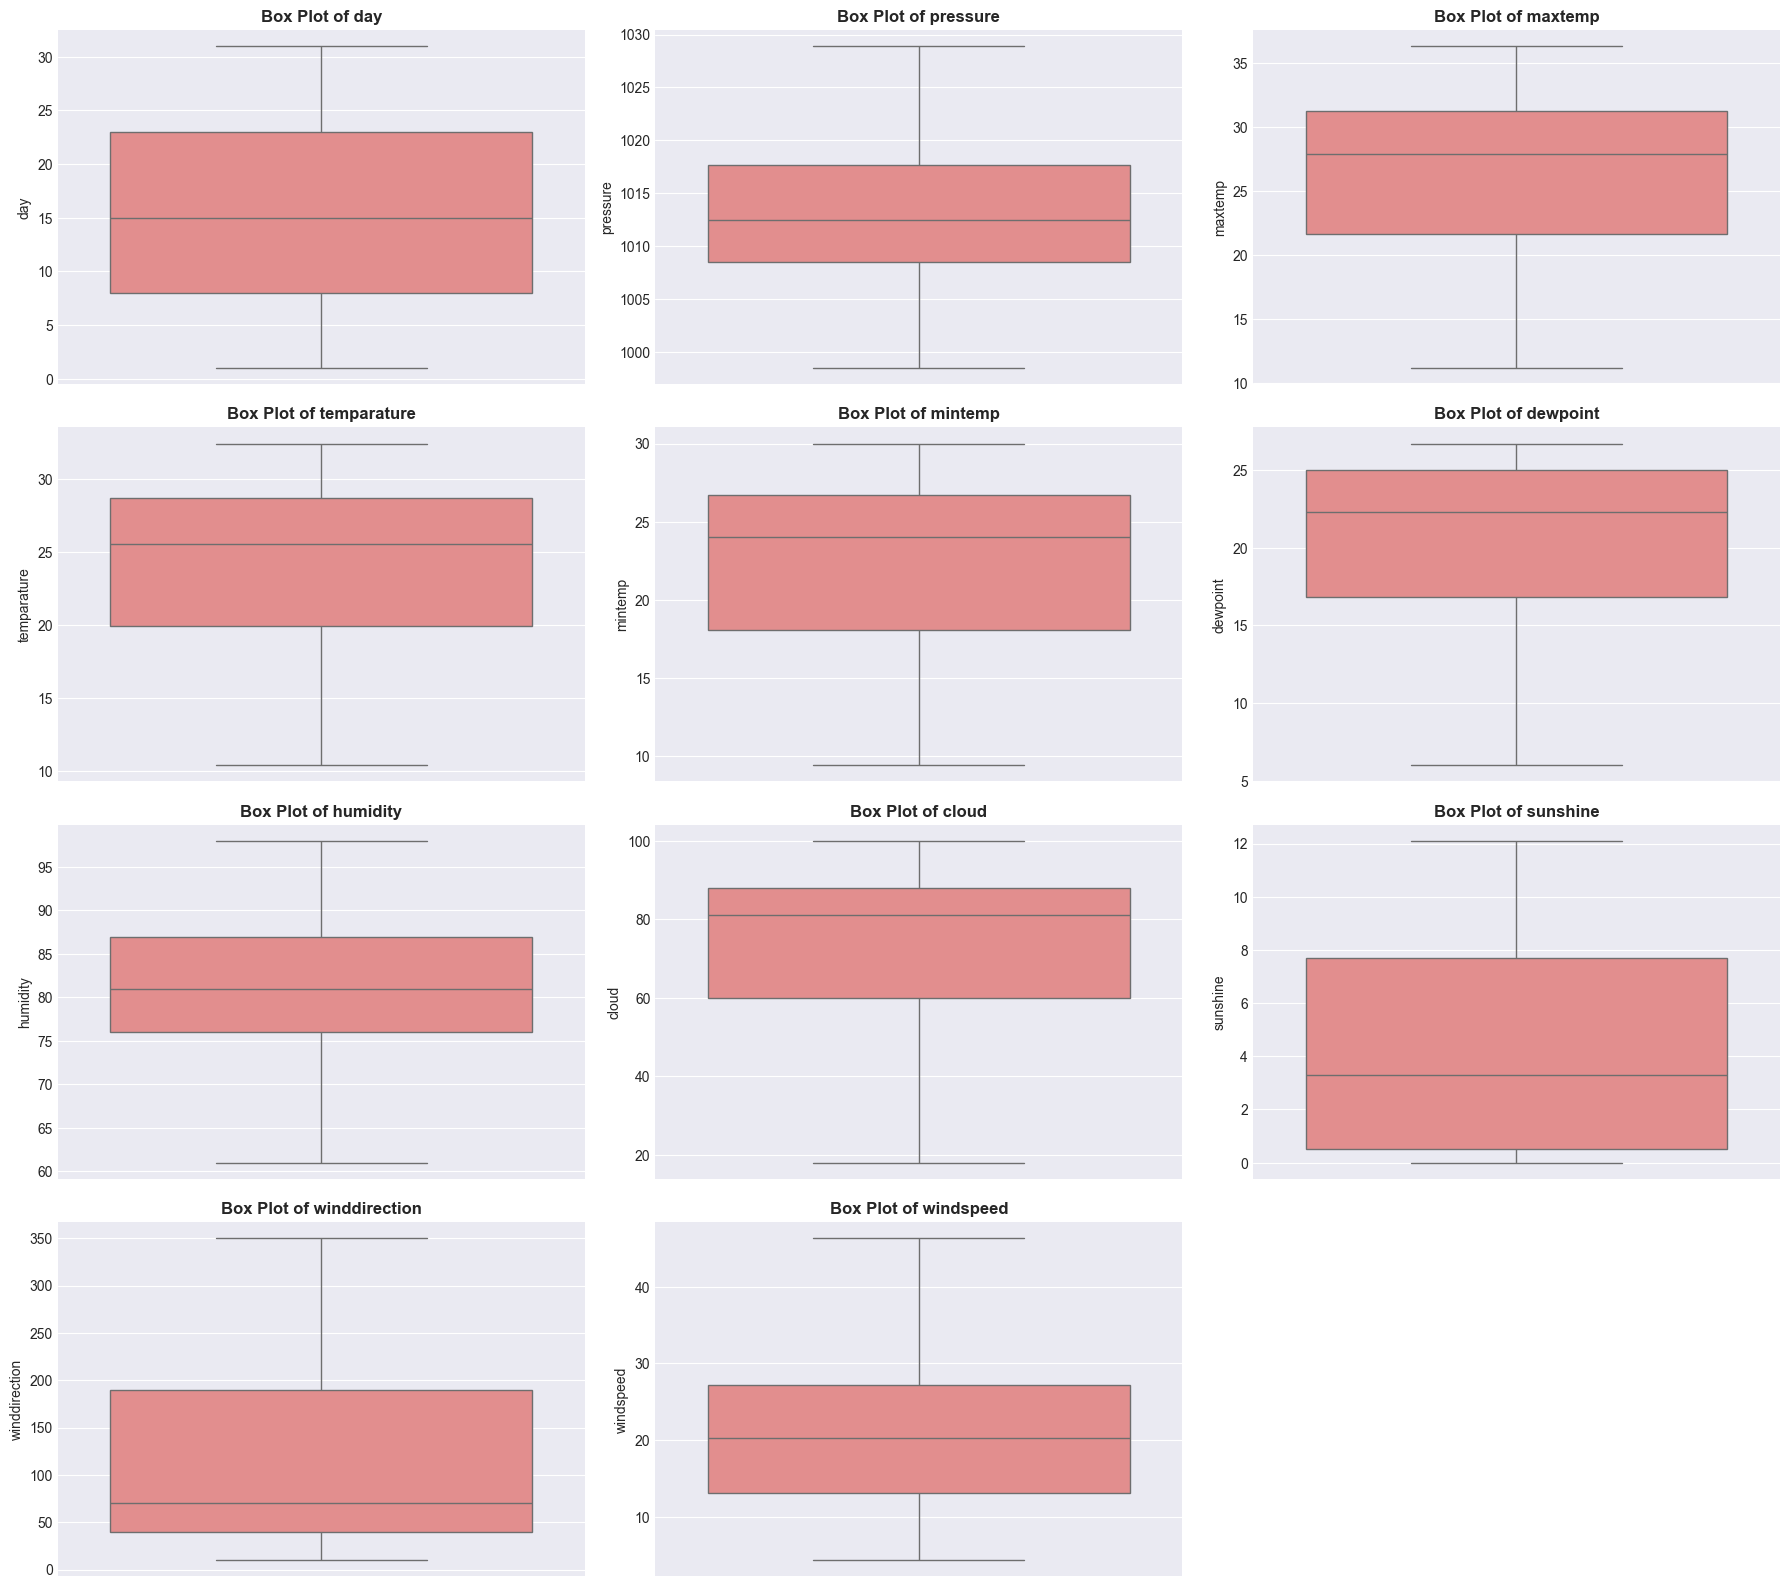

In [91]:
print("\nBox Plots for Outlier Detection")

fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    sns.boxplot(data=df, y=col, ax=axes[idx], color='lightcoral')
    axes[idx].set_title(f'Box Plot of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)

for i in range(num_cols, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Correlation Analysis


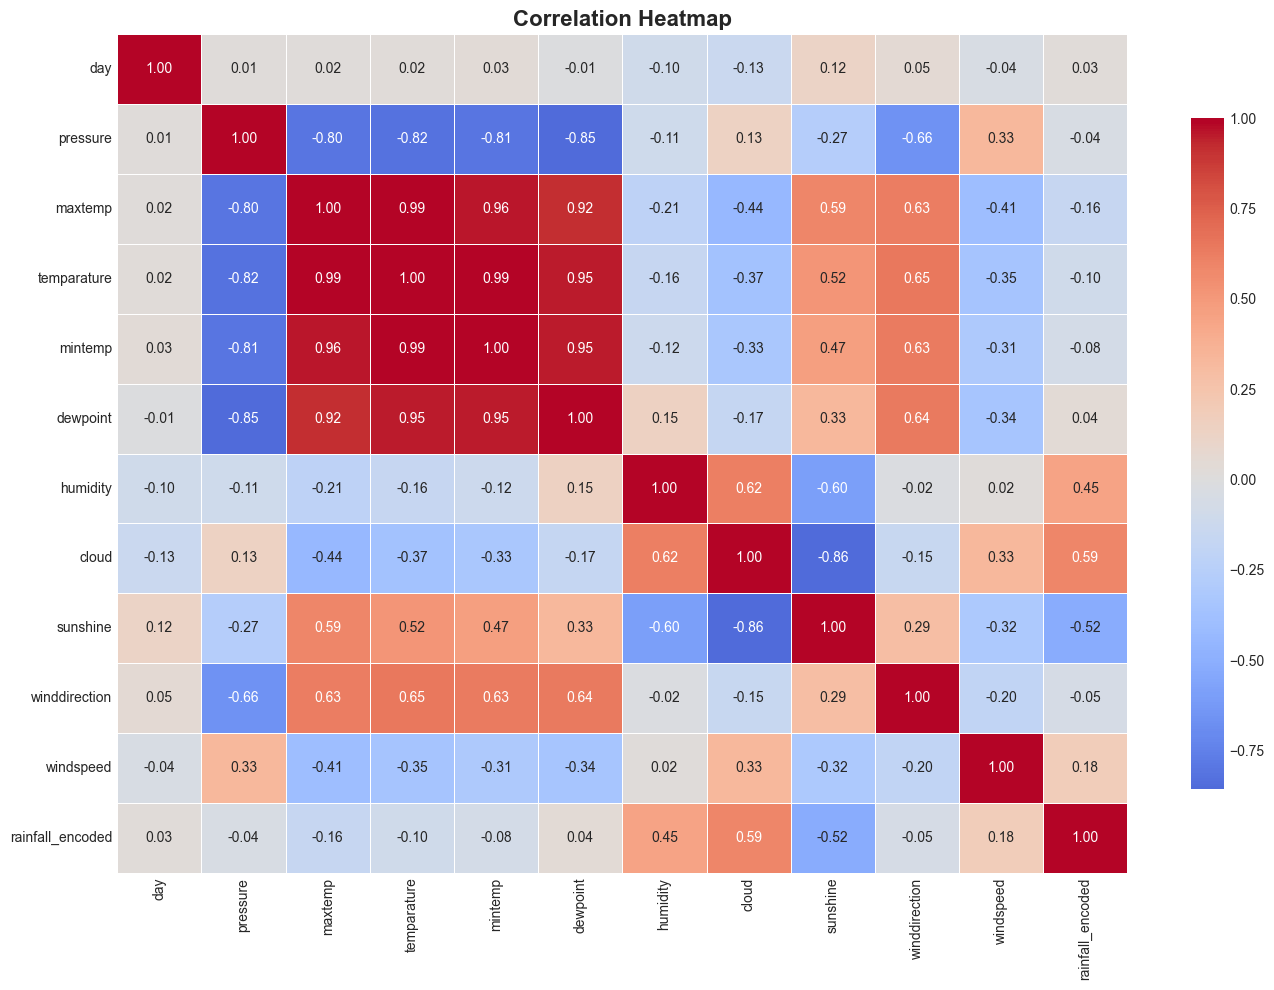


Features most correlated with Rainfall:
cloud            0.593286
sunshine         0.518643
humidity         0.445897
windspeed        0.180952
maxtemp          0.155084
temparature      0.098136
mintemp          0.075864
winddirection    0.053840
pressure         0.043610
dewpoint         0.043533
day              0.026265
Name: rainfall_encoded, dtype: float64


In [92]:
print("\nCorrelation Analysis")

df_corr = df.copy()

df_corr['rainfall_encoded'] = df_corr['rainfall'].map({'yes': 1, 'no': 0})

correlation_matrix = df_corr[numerical_features + ['rainfall_encoded']].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Features most correlated with target
print("\nFeatures most correlated with Rainfall:")
target_corr = correlation_matrix['rainfall_encoded'].drop('rainfall_encoded').abs().sort_values(ascending=False)
print(target_corr)


Pairplot of Top Correlated Features
Top 5 features: ['cloud', 'sunshine', 'humidity', 'windspeed', 'maxtemp']


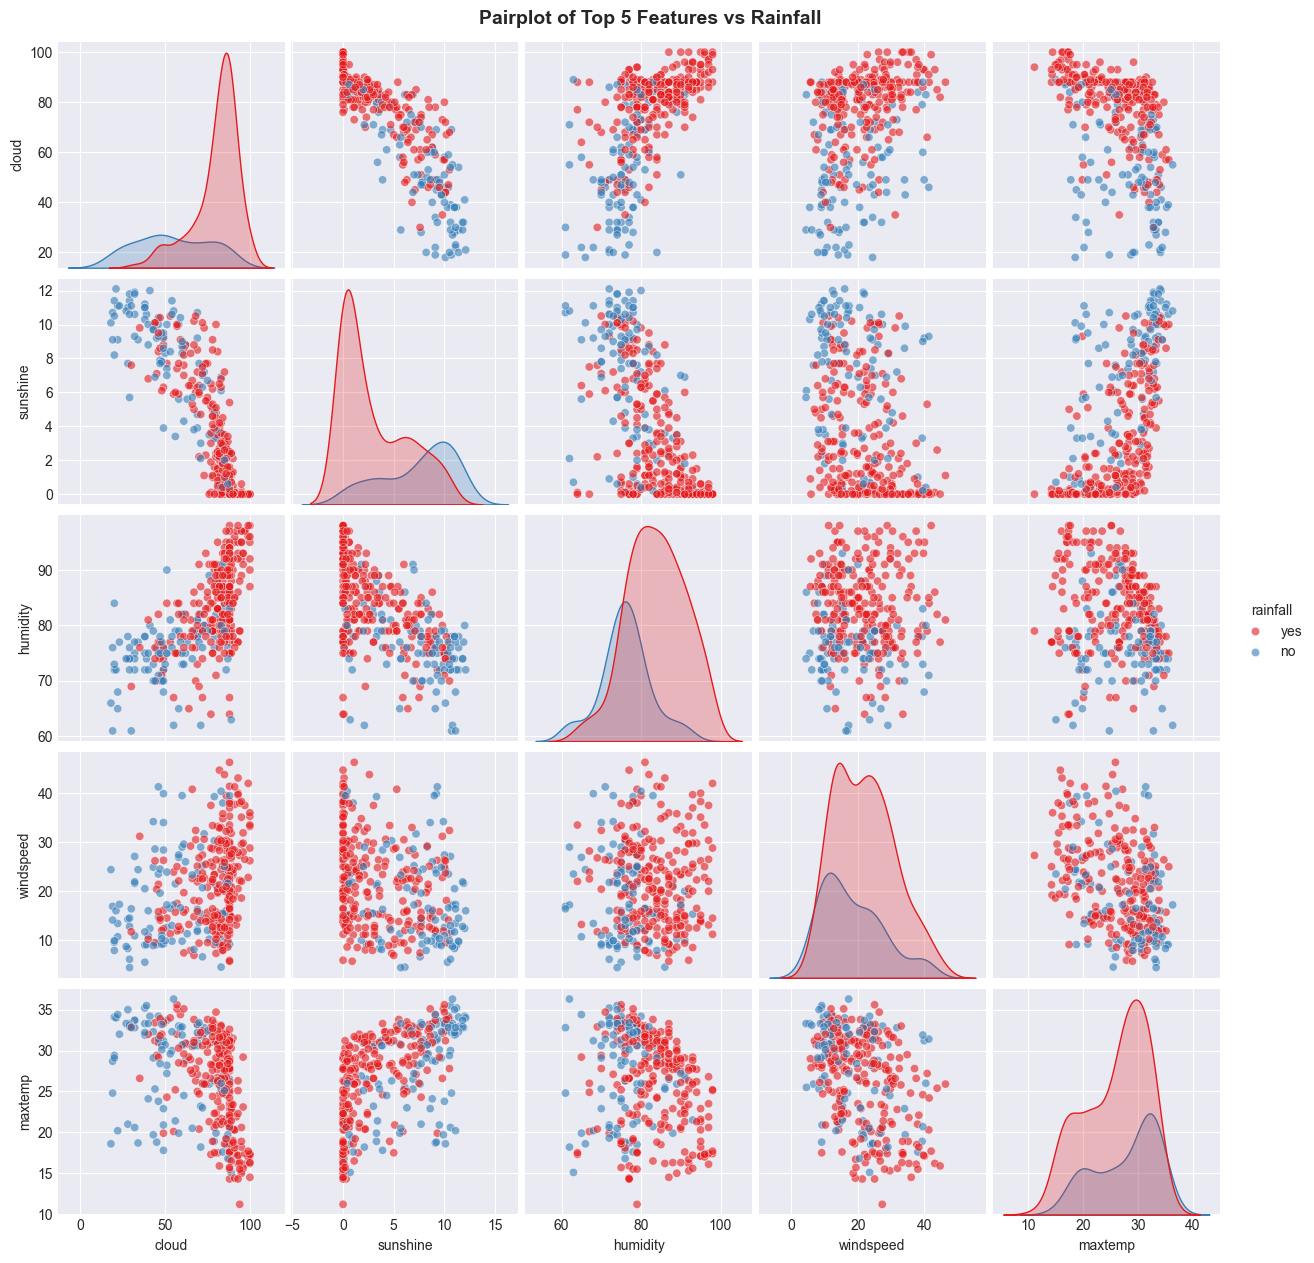

In [93]:
# Pairplot for selected features
print("\nPairplot of Top Correlated Features")

# Selecting top 5 features most correlated with target

top_features = target_corr.head(5).index.tolist()
print(f"Top 5 features: {top_features}")

# Creating pairplot
pairplot_df = df[top_features + ['rainfall']]
sns.pairplot(pairplot_df, hue='rainfall', palette='Set1', diag_kind='kde', 
             plot_kws={'alpha': 0.6}, height=2.5)
plt.suptitle('Pairplot of Top 5 Features vs Rainfall', y=1.01, fontsize=14, fontweight='bold')
plt.show()

---
## 6. Feature Engineering & Data Preprocessing

In [94]:
df_processed = df.copy()

# 1. Encoding the target variable
label_encoder = LabelEncoder()
df_processed['rainfall'] = label_encoder.fit_transform(df_processed['rainfall'])


# 2. Removing day column as its just an index
df_processed = df_processed.drop('day', axis=1)


print(f"\nFinal dataset shape: {df_processed.shape}")
print(f"Features: {df_processed.columns.tolist()}")


Final dataset shape: (343, 11)
Features: ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection', 'windspeed']


In [95]:
# Separating features and target
X = df_processed.drop('rainfall', axis=1)
y = df_processed['rainfall']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")

Features shape: (343, 10)
Target shape: (343,)

Feature columns: ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


---
## 7. Train-Test Split

In [96]:
# Splitting the data with stratification to maintain class balance

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # for imbalanced datasets
)

print("Data Split Summary:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Data Split Summary:
Training set size: 274 samples
Test set size: 69 samples

Training set class distribution:
rainfall
1    193
0     81
Name: count, dtype: int64

Test set class distribution:
rainfall
1    48
0    21
Name: count, dtype: int64


---
## 8. Feature Scaling

In [97]:
# Standardizing features using StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

---
## 9. Handle Class Imbalance with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic samples for the minority class to balance the dataset.

In [98]:
# Applying SMOTE to training data only 
print("Before SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

print(f"New training set size: {X_train_resampled.shape[0]} samples")

Before SMOTE:
rainfall
1    193
0     81
Name: count, dtype: int64

After SMOTE:
rainfall
0    193
1    193
Name: count, dtype: int64
New training set size: 386 samples


---
## 10. Model Training & Evaluation

We'll train multiple classification models and compare their performance.

In [99]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")
    
    # Training the model
    model.fit(X_train, y_train)
    
    # Making predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Printing results
    print(f"\n{model_name} Performance Metrics:")
    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Rainfall', 'Rainfall']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Rainfall', 'Rainfall'],
                yticklabels=['No Rainfall', 'Rainfall'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Returning metrics dictionary
    return {
        'model_name': model_name,
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'predictions_proba': y_pred_proba
    }

### 10.1 Baseline Models (Without Hyperparameter Tuning)


Training Logistic Regression...

Logistic Regression Performance Metrics:

Accuracy:  0.7681
Precision: 0.8045
Recall:    0.7681
F1-Score:  0.7761

Detailed Classification Report:
              precision    recall  f1-score   support

 No Rainfall       0.59      0.81      0.68        21
    Rainfall       0.90      0.75      0.82        48

    accuracy                           0.77        69
   macro avg       0.74      0.78      0.75        69
weighted avg       0.80      0.77      0.78        69



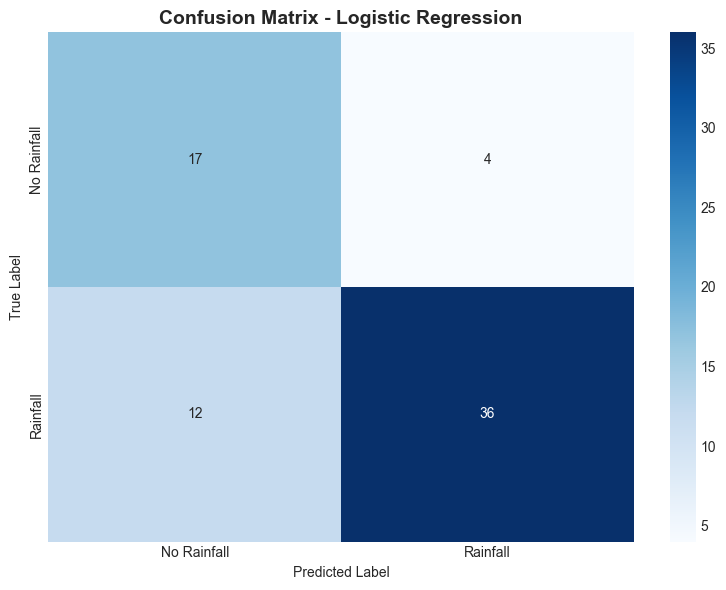

In [100]:
# Dictionary to store baseline model results
baseline_results = {}

# 1. Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_results['Logistic Regression'] = evaluate_model(
    lr_model, X_train_resampled, y_train_resampled, X_test_scaled, y_test, 'Logistic Regression'
)


Training Random Forest...

Random Forest Performance Metrics:

Accuracy:  0.7971
Precision: 0.8114
Recall:    0.7971
F1-Score:  0.8015

Detailed Classification Report:
              precision    recall  f1-score   support

 No Rainfall       0.64      0.76      0.70        21
    Rainfall       0.89      0.81      0.85        48

    accuracy                           0.80        69
   macro avg       0.76      0.79      0.77        69
weighted avg       0.81      0.80      0.80        69



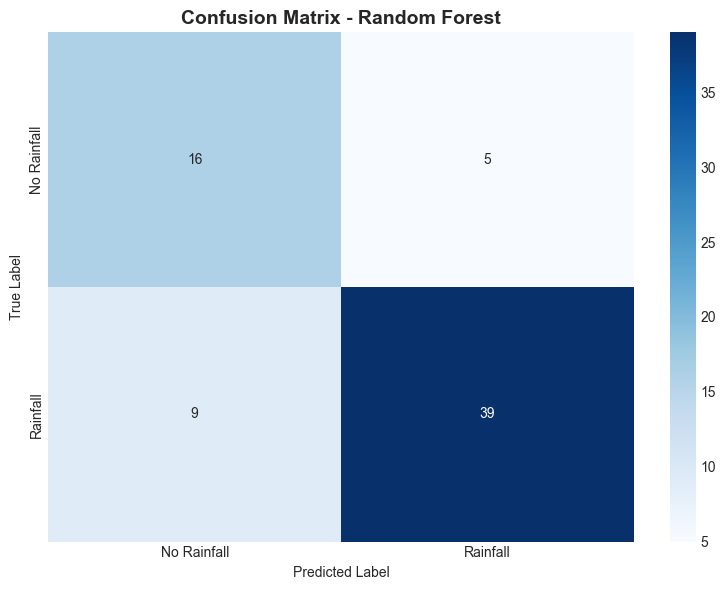

In [101]:
# 2. Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
baseline_results['Random Forest'] = evaluate_model(
    rf_model, X_train_resampled, y_train_resampled, X_test_scaled, y_test, 'Random Forest'
)


Training Gradient Boosting...

Gradient Boosting Performance Metrics:

Accuracy:  0.7971
Precision: 0.8034
Recall:    0.7971
F1-Score:  0.7996

Detailed Classification Report:
              precision    recall  f1-score   support

 No Rainfall       0.65      0.71      0.68        21
    Rainfall       0.87      0.83      0.85        48

    accuracy                           0.80        69
   macro avg       0.76      0.77      0.77        69
weighted avg       0.80      0.80      0.80        69



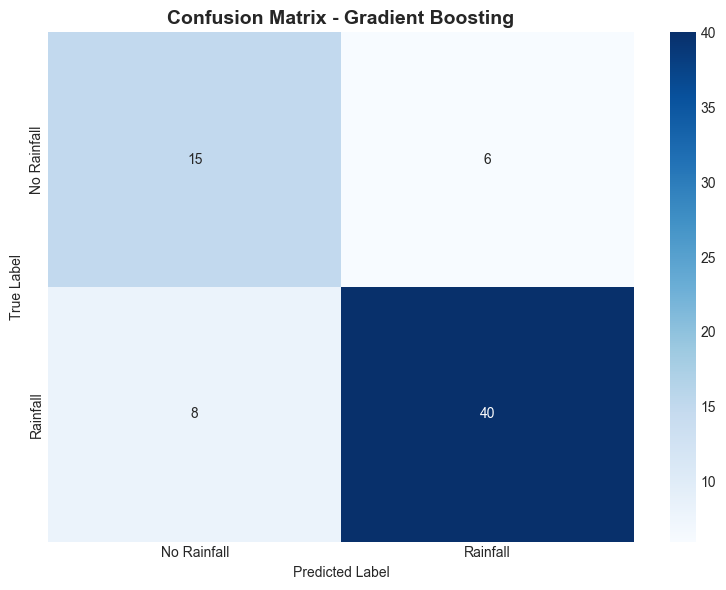

In [102]:
# 3. Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
baseline_results['Gradient Boosting'] = evaluate_model(
    gb_model, X_train_resampled, y_train_resampled, X_test_scaled, y_test, 'Gradient Boosting'
)


Training XGBoost...

XGBoost Performance Metrics:

Accuracy:  0.7971
Precision: 0.7971
Recall:    0.7971
F1-Score:  0.7971

Detailed Classification Report:
              precision    recall  f1-score   support

 No Rainfall       0.67      0.67      0.67        21
    Rainfall       0.85      0.85      0.85        48

    accuracy                           0.80        69
   macro avg       0.76      0.76      0.76        69
weighted avg       0.80      0.80      0.80        69



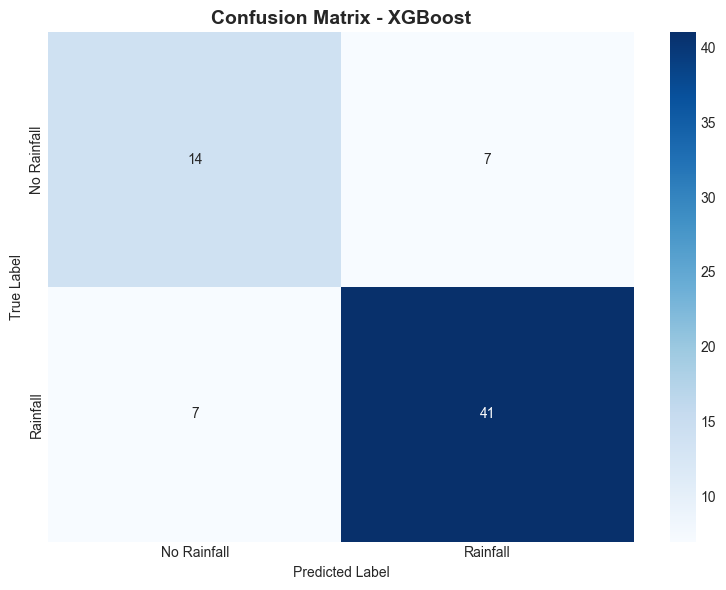

In [103]:
# 4. XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)
baseline_results['XGBoost'] = evaluate_model(
    xgb_model, X_train_resampled, y_train_resampled, X_test_scaled, y_test, 'XGBoost'
)


BASELINE MODELS COMPARISON

               Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.797101   0.811383 0.797101  0.801512
  Gradient Boosting  0.797101   0.803403 0.797101  0.799554
            XGBoost  0.797101   0.797101 0.797101  0.797101
Logistic Regression  0.768116   0.804498 0.768116  0.776126


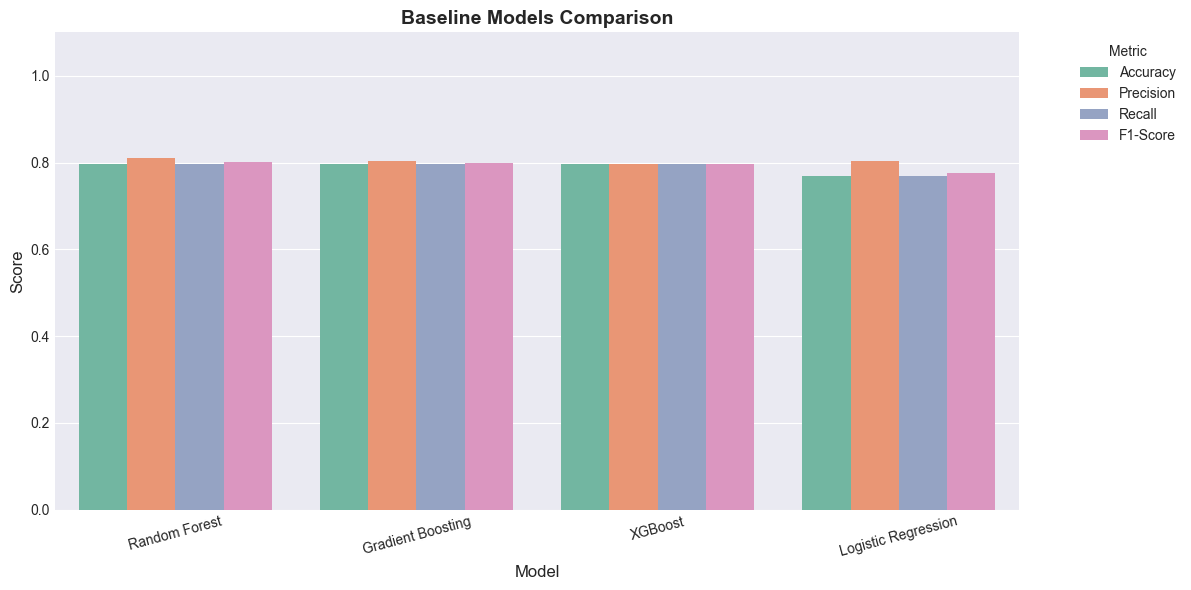

In [104]:
# Compare baseline models
print("\n" + "="*80)
print("BASELINE MODELS COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': [result['model_name'] for result in baseline_results.values()],
    'Accuracy': [result['accuracy'] for result in baseline_results.values()],
    'Precision': [result['precision'] for result in baseline_results.values()],
    'Recall': [result['recall'] for result in baseline_results.values()],
    'F1-Score': [result['f1_score'] for result in baseline_results.values()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print("\n", comparison_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
comparison_df_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=comparison_df_melted, x='Model', y='Score', hue='Metric', ax=ax, palette='Set2')
ax.set_title('Baseline Models Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylim(0, 1.1)
plt.xticks(rotation=15)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---
## 11. Hyperparameter Tuning with Optuna

We'll use Optuna to find the best hyperparameters for our top-performing models.

In [105]:
# Suppressing Optuna's verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Dictionary to store optimized model results
optimized_results = {}

### 11.1 Tuning Random Forest

Optimizing Random Forest...


Best trial: 25. Best value: 0.869796: 100%|██████████| 50/50 [01:18<00:00,  1.56s/it]



Best F1-Score: 0.8698
Best parameters: {'n_estimators': 397, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}

Training Random Forest (Optimized)...

Random Forest (Optimized) Performance Metrics:

Accuracy:  0.8116
Precision: 0.8213
Recall:    0.8116
F1-Score:  0.8148

Detailed Classification Report:
              precision    recall  f1-score   support

 No Rainfall       0.67      0.76      0.71        21
    Rainfall       0.89      0.83      0.86        48

    accuracy                           0.81        69
   macro avg       0.78      0.80      0.79        69
weighted avg       0.82      0.81      0.81        69



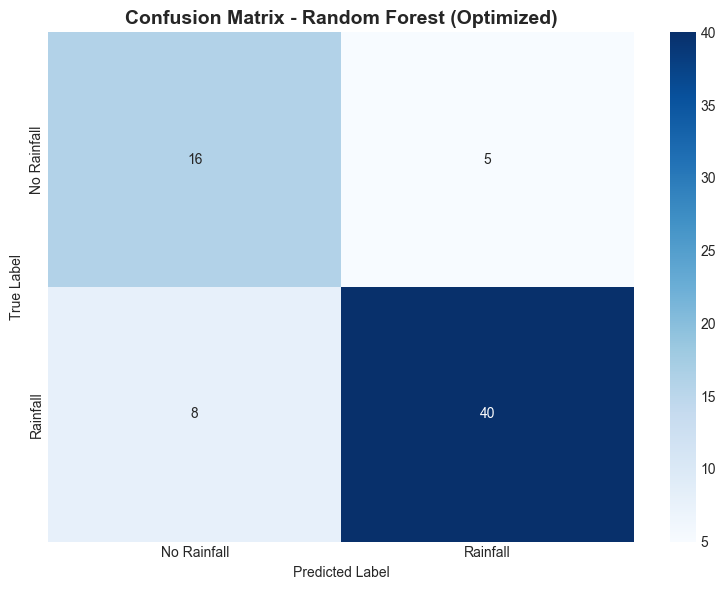

In [106]:
def optimize_random_forest(trial):
    
    # Defining hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Creating model with suggested parameters
    model = RandomForestClassifier(**params)
    
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                             cv=cv, scoring='f1_weighted', n_jobs=-1)
    
    return scores.mean()

# Running optimization
print("Optimizing Random Forest...")
study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_rf.optimize(optimize_random_forest, n_trials=50, show_progress_bar=True)

print(f"\nBest F1-Score: {study_rf.best_value:.4f}")
print(f"Best parameters: {study_rf.best_params}")

# Training final model with best parameters
best_rf = RandomForestClassifier(**study_rf.best_params)
optimized_results['Random Forest (Optimized)'] = evaluate_model(
    best_rf, X_train_resampled, y_train_resampled, X_test_scaled, y_test, 'Random Forest (Optimized)'
)

### 11.2 Tuning XGBoost

Optimizing XGBoost...


Best trial: 0. Best value: 0.849219: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s]



Best F1-Score: 0.8492
Best parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973}

Training XGBoost (Optimized)...

XGBoost (Optimized) Performance Metrics:

Accuracy:  0.7681
Precision: 0.7627
Recall:    0.7681
F1-Score:  0.7647

Detailed Classification Report:
              precision    recall  f1-score   support

 No Rainfall       0.63      0.57      0.60        21
    Rainfall       0.82      0.85      0.84        48

    accuracy                           0.77        69
   macro avg       0.73      0.71      0.72        69
weighted avg       0.76      0.77      0.76        69



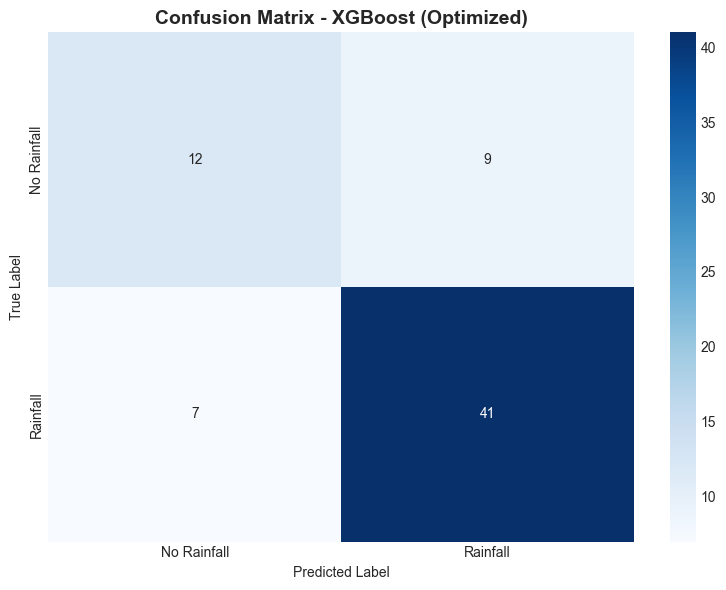

In [107]:
def optimize_xgboost(trial):
    # Defining hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'eval_metric': 'logloss',
        'n_jobs': -1
    }
    
    # Creating model with suggested parameters
    model = XGBClassifier(**params)
    
    # Performing cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                             cv=cv, scoring='f1_weighted', n_jobs=-1)
    
    return scores.mean()

# Running optimization
print("Optimizing XGBoost...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(optimize_xgboost, n_trials=50, show_progress_bar=True)

print(f"\nBest F1-Score: {study_xgb.best_value:.4f}")
print(f"Best parameters: {study_xgb.best_params}")

# Train final model with best parameters
best_xgb = XGBClassifier(**study_xgb.best_params)
optimized_results['XGBoost (Optimized)'] = evaluate_model(
    best_xgb, X_train_resampled, y_train_resampled, X_test_scaled, y_test, 'XGBoost (Optimized)'
)

### 11.3 Tuning Gradient Boosting

Optimizing Gradient Boosting...


Best trial: 32. Best value: 0.880265: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]



Best F1-Score: 0.8803
Best parameters: {'n_estimators': 338, 'max_depth': 8, 'learning_rate': 0.19974990348649507, 'subsample': 0.7558035025019946, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}

Training Gradient Boosting (Optimized)...

Gradient Boosting (Optimized) Performance Metrics:

Accuracy:  0.8116
Precision: 0.8063
Recall:    0.8116
F1-Score:  0.8072

Detailed Classification Report:
              precision    recall  f1-score   support

 No Rainfall       0.72      0.62      0.67        21
    Rainfall       0.84      0.90      0.87        48

    accuracy                           0.81        69
   macro avg       0.78      0.76      0.77        69
weighted avg       0.81      0.81      0.81        69



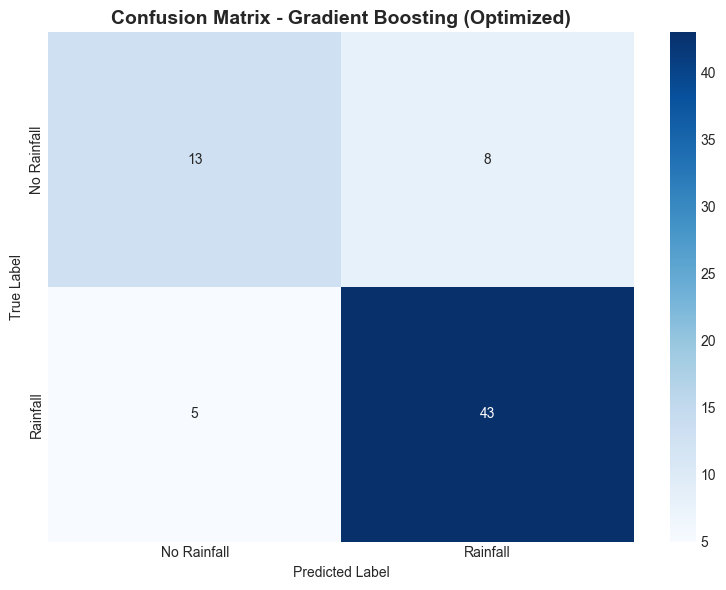

In [108]:
def optimize_gradient_boosting(trial):
    # Defining hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    
    # Creating model with suggested parameters
    model = GradientBoostingClassifier(**params)
    
    # Performing cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                             cv=cv, scoring='f1_weighted', n_jobs=-1)
    
    return scores.mean()

# Running optimization
print("Optimizing Gradient Boosting...")
study_gb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_gb.optimize(optimize_gradient_boosting, n_trials=50, show_progress_bar=True)

print(f"\nBest F1-Score: {study_gb.best_value:.4f}")
print(f"Best parameters: {study_gb.best_params}")

# Train final model with best parameters
best_gb = GradientBoostingClassifier(**study_gb.best_params)
optimized_results['Gradient Boosting (Optimized)'] = evaluate_model(
    best_gb, X_train_resampled, y_train_resampled, X_test_scaled, y_test, 'Gradient Boosting (Optimized)'
)

---
## 12. Final Model Comparison


FINAL MODEL COMPARISON (ALL MODELS)

                         Model  Accuracy  Precision   Recall  F1-Score
    Random Forest (Optimized)  0.811594   0.821256 0.811594  0.814836
Gradient Boosting (Optimized)  0.811594   0.806337 0.811594  0.807202
                Random Forest  0.797101   0.811383 0.797101  0.801512
            Gradient Boosting  0.797101   0.803403 0.797101  0.799554
                      XGBoost  0.797101   0.797101 0.797101  0.797101
          Logistic Regression  0.768116   0.804498 0.768116  0.776126
          XGBoost (Optimized)  0.768116   0.762654 0.768116  0.764685


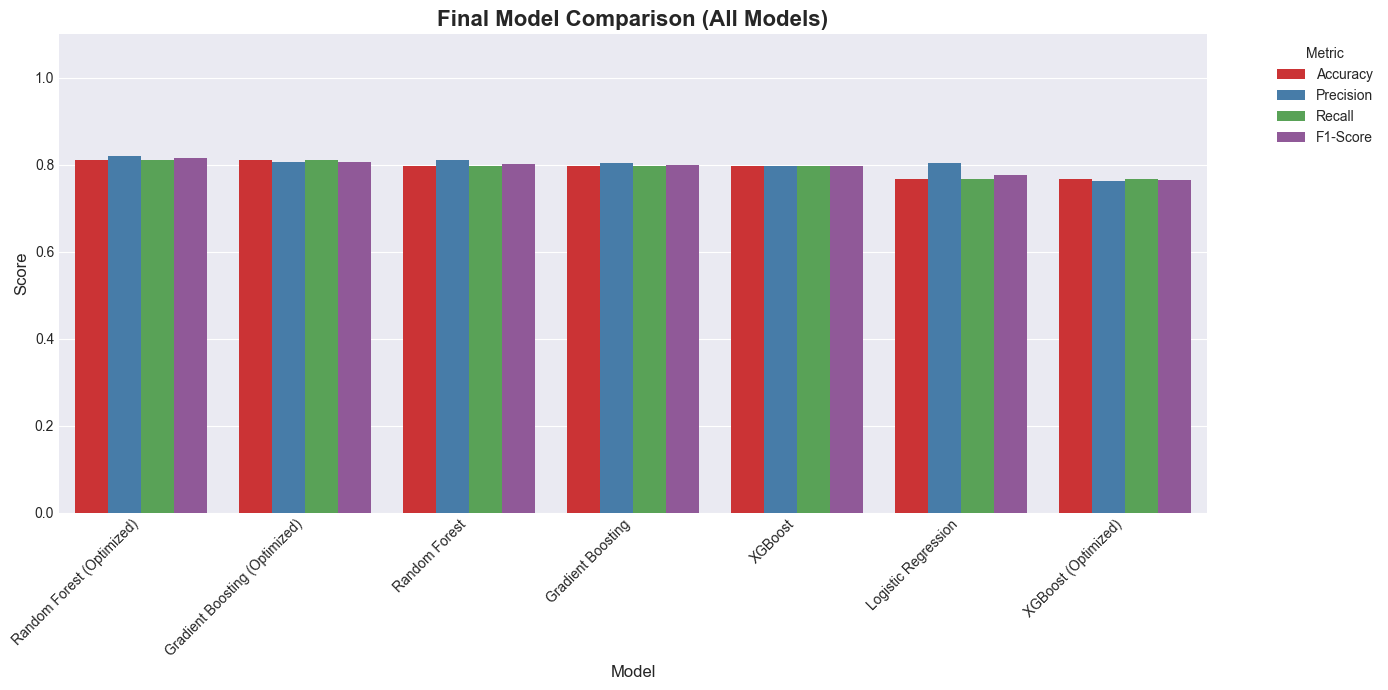


Best Model: Random Forest (Optimized)
Accuracy:  0.8116
Precision: 0.8213
Recall:    0.8116
F1-Score:  0.8148


In [109]:
all_results = {**baseline_results, **optimized_results}

print("\n" + "="*80)
print("FINAL MODEL COMPARISON (ALL MODELS)")
print("="*80)

final_comparison_df = pd.DataFrame({
    'Model': [result['model_name'] for result in all_results.values()],
    'Accuracy': [result['accuracy'] for result in all_results.values()],
    'Precision': [result['precision'] for result in all_results.values()],
    'Recall': [result['recall'] for result in all_results.values()],
    'F1-Score': [result['f1_score'] for result in all_results.values()]
})

final_comparison_df = final_comparison_df.sort_values('F1-Score', ascending=False)
print("\n", final_comparison_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(14, 7))
final_comparison_df_melted = final_comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=final_comparison_df_melted, x='Model', y='Score', hue='Metric', ax=ax, palette='Set1')
ax.set_title('Final Model Comparison (All Models)', fontsize=16, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

best_model_name = final_comparison_df.iloc[0]['Model']
best_model_metrics = final_comparison_df.iloc[0]

print("\n" + "="*80)
print(f"Best Model: {best_model_name}")
print("="*80)
print(f"Accuracy:  {best_model_metrics['Accuracy']:.4f}")
print(f"Precision: {best_model_metrics['Precision']:.4f}")
print(f"Recall:    {best_model_metrics['Recall']:.4f}")
print(f"F1-Score:  {best_model_metrics['F1-Score']:.4f}")

best_model_obj = all_results[best_model_name]['model']

---
## 13. Save the Best Model and Preprocessing Objects

We'll save:
1. The best trained model
2. The scaler (for preprocessing new data)
3. The label encoder (for decoding predictions)
4. Feature names (for consistency)

In [110]:
import os

# Creating models directory if it doesn't exist
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Saving the best model
model_path = os.path.join(models_dir, 'best_rainfall_model.pkl')
joblib.dump(best_model_obj, model_path)
print(f"Best model saved to: {model_path}")

# Saving the scaler
scaler_path = os.path.join(models_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Saving the label encoder
label_encoder_path = os.path.join(models_dir, 'label_encoder.pkl')
joblib.dump(label_encoder, label_encoder_path)
print(f"Label encoder saved to: {label_encoder_path}")

# Saving feature names
feature_names_path = os.path.join(models_dir, 'feature_names.pkl')
joblib.dump(X.columns.tolist(), feature_names_path)
print(f"Feature names saved to: {feature_names_path}")

# Saving model metadata
metadata = {
    'model_name': best_model_name,
    'accuracy': float(best_model_metrics['Accuracy']),
    'precision': float(best_model_metrics['Precision']),
    'recall': float(best_model_metrics['Recall']),
    'f1_score': float(best_model_metrics['F1-Score']),
    'features': X.columns.tolist(),
    'classes': label_encoder.classes_.tolist()
}

metadata_path = os.path.join(models_dir, 'model_metadata.pkl')
joblib.dump(metadata, metadata_path)
print(f"Model metadata saved to: {metadata_path}")

print("\n" + "="*80)
print("ALL MODELS AND PREPROCESSING OBJECTS SAVED SUCCESSFULLY!")
print("="*80)

Best model saved to: ../models\best_rainfall_model.pkl
Scaler saved to: ../models\scaler.pkl
Label encoder saved to: ../models\label_encoder.pkl
Feature names saved to: ../models\feature_names.pkl
Model metadata saved to: ../models\model_metadata.pkl

ALL MODELS AND PREPROCESSING OBJECTS SAVED SUCCESSFULLY!


---
## 14. Test Model Loading (Verification)

In [111]:
# Loading the saved model and verifying
print("Testing model loading...\n")

# Loading model
loaded_model = joblib.load(model_path)
print("Model loaded successfully")

# Loading scaler
loaded_scaler = joblib.load(scaler_path)
print("Scaler loaded successfully")

# Loading label encoder
loaded_label_encoder = joblib.load(label_encoder_path)
print("Label encoder loaded successfully")

# Loading feature names
loaded_feature_names = joblib.load(feature_names_path)
print("Feature names loaded successfully")

# Loading metadata
loaded_metadata = joblib.load(metadata_path)
print("Metadata loaded successfully")

print("\nLoaded metadata:")
for key, value in loaded_metadata.items():
    print(f"{key}: {value}")

# Testing prediction with a sample
sample = X_test.iloc[0:1]
sample_scaled = loaded_scaler.transform(sample)
prediction = loaded_model.predict(sample_scaled)
prediction_label = loaded_label_encoder.inverse_transform(prediction)

print(f"\nTest prediction: {prediction_label[0]}")
print(f"Actual value: {loaded_label_encoder.inverse_transform([y_test.iloc[0]])[0]}")

print("\nModel verification complete! Ready for deployment.")

Testing model loading...

Model loaded successfully
Scaler loaded successfully
Label encoder loaded successfully
Feature names loaded successfully
Metadata loaded successfully

Loaded metadata:
model_name: Random Forest (Optimized)
accuracy: 0.8115942028985508
precision: 0.821256038647343
recall: 0.8115942028985508
f1_score: 0.81483559295621
features: ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
classes: ['no', 'yes']

Test prediction: yes
Actual value: yes

Model verification complete! Ready for deployment.
